In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models


import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
label_map = {"Dirt":"0","Muddy":"1","Normal":"2","Rocky":"3","Sandy":"4", "Snowy":"5","Wet":"6"}

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
data_path = "/content/gdrive/My\ Drive/data/"

In [5]:
# go to the folder:
%cd /content/gdrive/My\ Drive/data/
# print out the content of the folder:
%ls

%cd Updated_Terrain_Classification_Dataset
%ls

/content/gdrive/My Drive/data
 Driveable_Classification_Dataset/   TerrainAndDriveableModel.pt
 Driveable_Dataset/                  Terrain_Classification_Dataset/
 Flowers/                            Terrain_Classification_DataSet/
 __MACOSX/                           Test_Driveable_Classification_Dataset/
 MiniImageNet/                       Test.txt
 MNIST/                              Train.txt
'SRA Paper Methods: Dataset.gdoc'    Updated_Terrain_Classification_Dataset/
 Terrain/                            Updated_Terrain_Classification_Dataset.zip
/content/gdrive/My Drive/data/Updated_Terrain_Classification_Dataset
Test/  Train/


In [6]:
batch_size = 16
num_workers = 0

train_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(10),
      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# define datasets:
train_data = datasets.ImageFolder("./Train", transform=train_transform)
test_data = datasets.ImageFolder("./Test", transform=test_transform)

# define dataloaders:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [8]:
# define model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features = 512, out_features = 7)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [9]:
"""Train (and validate):"""

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
# specify scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# number of epochs to train the model
n_epochs = 20

# lists to keep track of training progress:
train_loss_progress = []

model.train() # prep model for training

n_iterations = int(len(train_data)/batch_size)

# val_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for iter, (data, target) in enumerate(train_loader):  

        print("Epoch:", epoch, "Iteration:", iter, "out of:", n_iterations)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)

        # calculate the loss
        loss = criterion(outputs, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
      
    # if you have a learning rate scheduler - perform a its step in here
    scheduler.step()
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    train_loss_progress.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

    # Run the test pass:
    correct = 0
    total = 0
    model.eval()  # prep model for validation

    with torch.no_grad():
        for data, target in test_loader:
          outputs = model(data)
          _, predicted = torch.max(outputs.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (test_accuracy))

    test_accuracies.append(test_accuracy)

print('Best accuracy of the network on the test set: %d %%' % (max(test_accuracies)))
print('Average accuracy of the network on the test set: %d %%' % (sum(test_accuracies) / len(test_accuracies)))





Epoch: 0 Iteration: 0 out of: 20
Epoch: 0 Iteration: 1 out of: 20
Epoch: 0 Iteration: 2 out of: 20
Epoch: 0 Iteration: 3 out of: 20
Epoch: 0 Iteration: 4 out of: 20
Epoch: 0 Iteration: 5 out of: 20
Epoch: 0 Iteration: 6 out of: 20
Epoch: 0 Iteration: 7 out of: 20
Epoch: 0 Iteration: 8 out of: 20
Epoch: 0 Iteration: 9 out of: 20
Epoch: 0 Iteration: 10 out of: 20
Epoch: 0 Iteration: 11 out of: 20
Epoch: 0 Iteration: 12 out of: 20
Epoch: 0 Iteration: 13 out of: 20
Epoch: 0 Iteration: 14 out of: 20
Epoch: 0 Iteration: 15 out of: 20
Epoch: 0 Iteration: 16 out of: 20
Epoch: 0 Iteration: 17 out of: 20
Epoch: 0 Iteration: 18 out of: 20
Epoch: 0 Iteration: 19 out of: 20
Epoch: 0 Iteration: 20 out of: 20
Epoch: 1 	Training Loss: 1.866407
Accuracy of the network on the test set: 40 %
Epoch: 1 Iteration: 0 out of: 20
Epoch: 1 Iteration: 1 out of: 20
Epoch: 1 Iteration: 2 out of: 20
Epoch: 1 Iteration: 3 out of: 20
Epoch: 1 Iteration: 4 out of: 20
Epoch: 1 Iteration: 5 out of: 20
Epoch: 1 Iteration

In [10]:
n_epochs = 20
# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  labels = list(label_map.keys())
  df_cm = pd.DataFrame(cm, index = labels, columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title("Confusion Matrix")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()


# Print accuracy, precision, recall, f1
def printStats(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred) * 100
  precision = precision_score(y_true, y_pred, average="macro") * 100
  recall = recall_score(y_true, y_pred, average="macro") * 100
  f1 = f1_score(y_true, y_pred, average="macro") * 100

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1_score:", f1)
  return accuracy, precision, recall, f1


# Plot testing accuracy
def plot_graph(data, label):
  x_range_acc_t = np.arange(1, len(data) + 1)
  fig, axs = plt.subplots()
  axs.plot(x_range_acc_t, data, c='r', label=label)
  axs.legend()
  plt.ylabel('testing accuracy' if label == 'Test accuracy' else 'train loss')
  plt.xlabel('epoch')
  plt.xticks(range(0, n_epochs + 1, 5), range(0, n_epochs+1, 5))
  plt.grid(b=True, which='major', axis='y')
  plt.show()
  plt.close()


def save_model_info(model, model_name, loss, test_acc, acc, pre, recall, f1):
  PATH = f"./{model_name}_model.pt"
  torch.save({
              'model_state_dict': model.state_dict(),
              'train_loss_progress': loss,
              'test_accuracies': test_acc,
              'accuracy': acc,
              'precision': pre,
              'recall': recall,
              'f1': f1
            }, PATH)

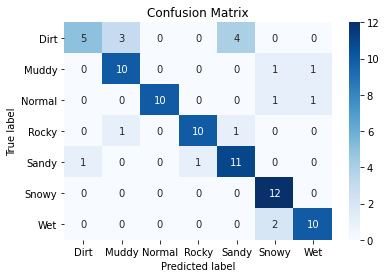

In [11]:
# Plot confusion matrix
# checkpoint = torch.load("./Terrain_resnet18_model.pt")
# model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()

target_vals = np.array([])
predicted_vals = np.array([])

with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data,1)
            predicted_vals = np.concatenate([predicted_vals, predicted.tolist()])
            target_vals = np.concatenate([target_vals, target.tolist()])

plot_confusion_matrix(target_vals, predicted_vals)

In [12]:
# Print accuracy, precision, recall, f1
accuracy, precision, recall, f1 = printStats(target_vals, predicted_vals)

Accuracy: 80.0
Precision: 81.82204700061843
Recall: 79.94505494505493
F1_score: 79.32199044857


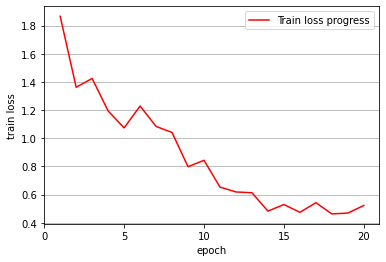

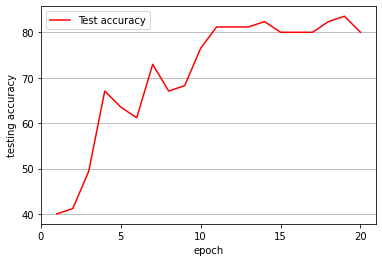

In [15]:
# Plot train_loss_progress, test_accuracies_t, test_accuracies_d
checkpoint = torch.load("Terrain_resnet18_updated_model.pt")

plot_graph(checkpoint["train_loss_progress"], "Train loss progress")
plot_graph(checkpoint["test_accuracies"], "Test accuracy")

In [14]:
save_model_info(model, "Terrain_resnet18_updated", train_loss_progress, test_accuracies, accuracy, precision, recall, f1)